In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ipaddress
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [26]:
fraud_data = pd.read_csv('../../data/Fraud_Data.csv')
ip_country_data = pd.read_csv('../../data/IpAddress_to_Country.csv')

# Merge the two dataframes

numeric_cols = ['purchase_value', 'age']
fraud_data[numeric_cols] = fraud_data[numeric_cols].fillna(fraud_data[numeric_cols].median())

categorical_cols = ['source', 'browser', 'sex']
fraud_data[categorical_cols] = fraud_data[categorical_cols].fillna(fraud_data[categorical_cols].mode().iloc[0])


fraud_data = fraud_data.drop_duplicates()

# Converting signup_time and purchase_time to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

### convert ip to int and merge the dataframes

In [27]:
def ip_to_int(ip_str):
    try:
        return int(ipaddress.ip_address(ip_str))
    except ValueError:
        return np.nan
    
fraud_data['ip_address_int'] = fraud_data['ip_address'].apply(ip_to_int)

# Convert IP ranges in ip_country_data to integers
ip_country_data['lower_bound_ip_address_int'] = ip_country_data['lower_bound_ip_address'].apply(ip_to_int)
ip_country_data['upper_bound_ip_address_int'] = ip_country_data['upper_bound_ip_address'].apply(ip_to_int)

fraud_data['country'] = np.nan

for idx, row in ip_country_data.iterrows():
    mask = (fraud_data['ip_address_int'] >= row['lower_bound_ip_address_int']) & \
           (fraud_data['ip_address_int'] <= row['upper_bound_ip_address_int'])
    fraud_data.loc[mask, 'country'] = row['country']

/var/folders/b3/zdl2xxh53jgc4hjrq6hk1p9c0000gn/T/ipykernel_42071/187066466.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Australia' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fraud_data.loc[mask, 'country'] = row['country']


### EDA

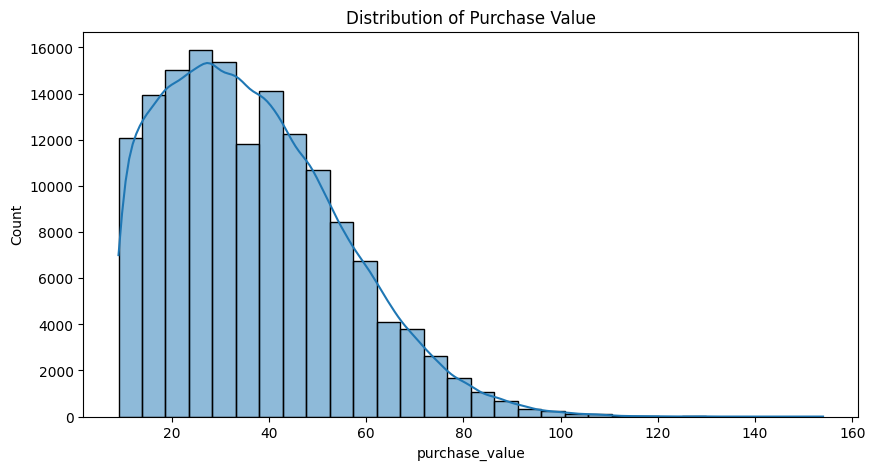

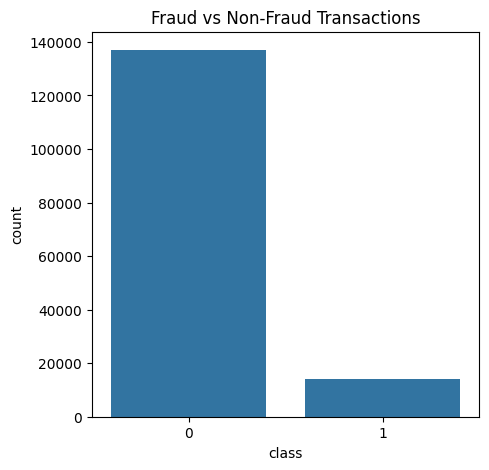

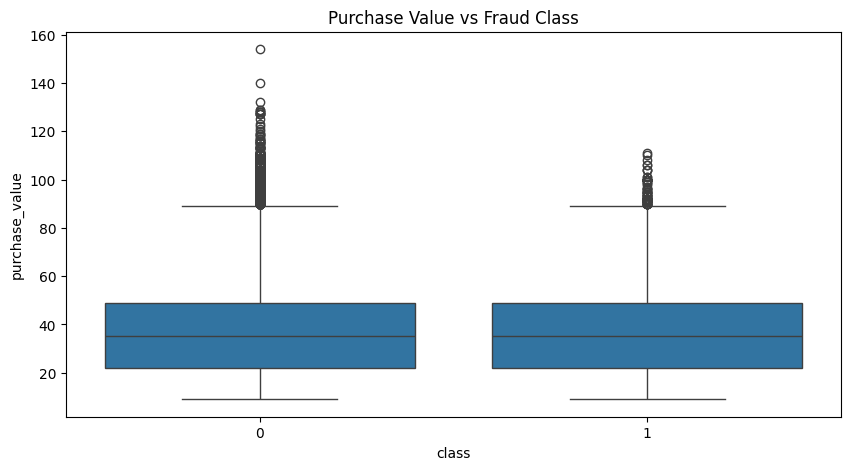

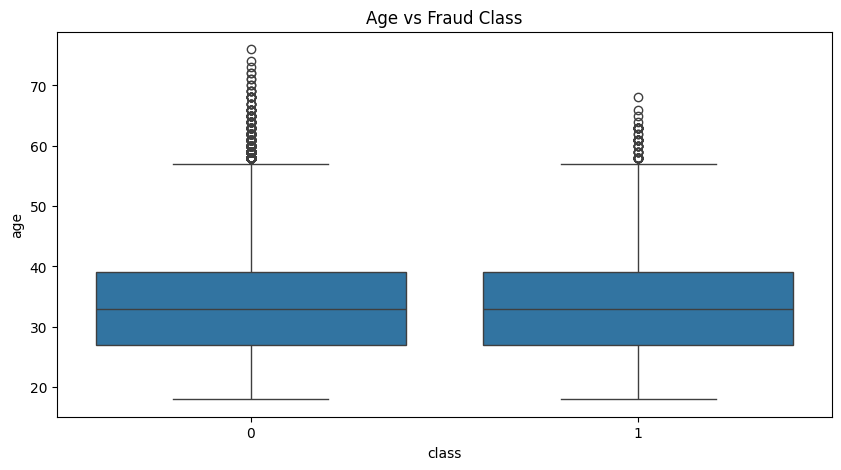

In [28]:
# Univariate analysis (Distribution of features)
plt.figure(figsize=(10, 5))
sns.histplot(fraud_data['purchase_value'], bins=30, kde=True)
plt.title('Distribution of Purchase Value')
plt.show()

plt.figure(figsize=(5, 5))
sns.countplot(x='class', data=fraud_data)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

# Bivariate analysis (Fraud based on purchase value and age)
plt.figure(figsize=(10, 5))
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title('Purchase Value vs Fraud Class')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='class', y='age', data=fraud_data)
plt.title('Age vs Fraud Class')
plt.show()

### Feature Engineering

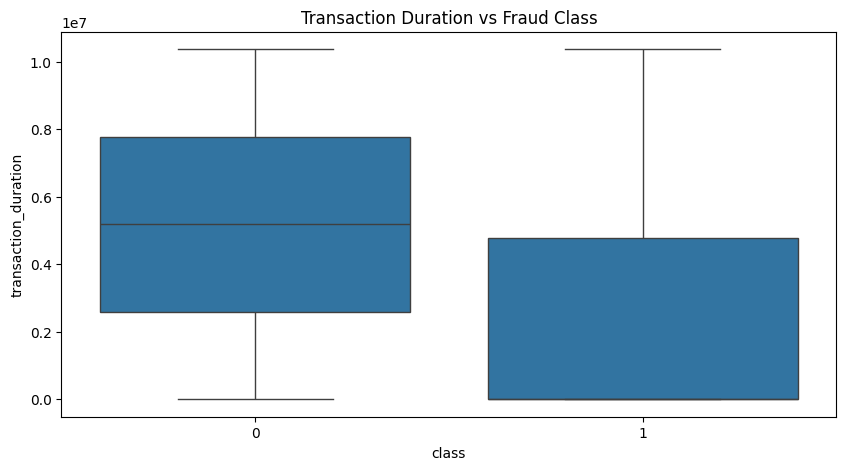

In [29]:
fraud_data['transaction_duration'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds().abs()

fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek

plt.figure(figsize=(10, 5))
sns.boxplot(x='class', y='transaction_duration', data=fraud_data)
plt.title('Transaction Duration vs Fraud Class')
plt.show()

### Normalizing and scaling the data

In [30]:
scaler = StandardScaler()

numeric_cols = ['purchase_value', 'age', 'transaction_duration']
fraud_data[numeric_cols] = scaler.fit_transform(fraud_data[numeric_cols])

print(fraud_data.head())

   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11       -0.160204   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54       -1.142592   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45       -1.197169   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50        0.385567   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53        0.112681   

       device_id source browser sex       age    ip_address  class  \
0  QVPSPJUOCKZAR    SEO  Chrome   M  0.679914  7.327584e+08      0   
1  EOGFQPIZPYXFZ    Ads  Chrome   F  2.304476  3.503114e+08      0   
2  YSSKYOSJHPPLJ    SEO   Opera   M  2.304476  2.621474e+09      1   
3  ATGTXKYKUDUQN    SEO  Safari   M  0.911994  3.840542e+09      0   
4  NAUITBZFJKHWW    Ads  Safari   M  1.376155  4.155831e+08      0   

   ip_address_int country  transaction_duration  hour_of_day  day_of_week  
0             NaN     NaN             -0.136057            2            5  
1     

### One Hot Encoding

In [31]:
categorical_cols = ['source', 'browser', 'sex', 'country']
encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_cols = pd.DataFrame(encoder.fit_transform(fraud_data[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

fraud_data = pd.concat([fraud_data, encoded_cols], axis=1)

fraud_data.drop(columns=categorical_cols + ['ip_address', 'ip_address_int'], inplace=True)

print(fraud_data.head())

   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11       -0.160204   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54       -1.142592   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45       -1.197169   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50        0.385567   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53        0.112681   

       device_id       age  class  transaction_duration  hour_of_day  \
0  QVPSPJUOCKZAR  0.679914      0             -0.136057            2   
1  EOGFQPIZPYXFZ  2.304476      0             -1.571877            1   
2  YSSKYOSJHPPLJ  2.304476      1             -1.577617           18   
3  ATGTXKYKUDUQN  0.911994      0             -1.420213           13   
4  NAUITBZFJKHWW  1.376155      0             -0.182509           18   

   day_of_week  source_Direct  source_SEO  browser_FireFox  browser_IE  \
0            5            0.0         1.0              0.0         0.0  

In [32]:
# Save the preprocessed data

fraud_data.to_csv('../../data/fraud_data_preprocessed.csv', index=False)